In [6]:
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

import numpy as np

In [7]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']

In [8]:
train_file = '../data/next_day_wildfire_spread_train*'
validation_file = '../data/next_day_wildfire_spread_eval*'
test_file = '../data/next_day_wildfire_spread_test*'

In [9]:
def normalize_feature(feature, feature_name):
    """ Normalize features except 'PrevFireMask'. """
    if feature_name == 'PrevFireMask':
        return feature
    else:
        return (feature - tf.reduce_mean(feature)) / (tf.math.reduce_std(feature) + 1e-6)

def _parse_function(example_proto):
    """ Parses TFRecord into tensors and normalizes features. """
    feature_description = {feat: tf.io.FixedLenFeature([64, 64], tf.float32) for feat in INPUT_FEATURES + OUTPUT_FEATURES}

    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    inputs_list = [normalize_feature(tf.expand_dims(parsed_example[feat], -1), feat) for feat in INPUT_FEATURES]
    inputs = tf.concat(inputs_list, axis=-1)  # Convert to NumPy

    label = tf.expand_dims(parsed_example['FireMask'], -1)  # Shape: [64, 64, 1]
    label = tf.where(label < 0, 0.0, label)
    label = tf.where(label > 0, 1.0, label)

    return inputs, label

In [10]:
def get_tensorflow_dataset(file_pattern):
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Convert train, validation, and test datasets
train_numpy = get_tensorflow_dataset(train_file)
val_numpy = get_tensorflow_dataset(validation_file)
test_numpy = get_tensorflow_dataset(test_file)

In [11]:
def convert_to_numpy(dataset):
    """ Convert TensorFlow dataset to NumPy arrays formatted for scikit-learn. """
    X, y = [], []
    for inputs, label in dataset:
        inputs = inputs.numpy()  # Convert to NumPy
        label = label.numpy()

        # Flatten from (64, 64, num_features) to (64*64, num_features)
        inputs = inputs.reshape(-1, inputs.shape[-1])
        label = label.reshape(-1)  # Flatten labels from (64, 64, 1) to (64*64,)

        X.append(inputs)
        y.append(label)

    # Concatenate all samples
    X = np.vstack(X)
    y = np.hstack(y)

    return X, y
X_train, y_train = convert_to_numpy(train_numpy)
X_val, y_val = convert_to_numpy(val_numpy)
X_test, y_test = convert_to_numpy(test_numpy)

2025-04-24 14:57:35.971120: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
sample_weights = compute_sample_weight('balanced', y_train)

In [13]:
param_grid = {'max_depth': [5, 10, 15, 20, None]}

In [14]:
rf = RandomForestClassifier(
    n_estimators=10,          
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=2,                 
    random_state=42
)

In [15]:
grid_search = GridSearchCV(
    rf,
    param_grid=param_grid,
    scoring='average_precision',
    cv=2,                     # 2-fold CV to reduce memory
    verbose=1,
    n_jobs=2
)

In [13]:
grid_search.fit(X_train, y_train, sample_weight=sample_weights)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


GridSearchCV(cv=2,
             estimator=RandomForestClassifier(min_samples_leaf=2,
                                              min_samples_split=5,
                                              n_estimators=10, n_jobs=2,
                                              random_state=42),
             n_jobs=2, param_grid={'max_depth': [5, 10, 15, 20, None]},
             scoring='average_precision', verbose=1)

In [15]:
print("Best max_depth:", grid_search.best_params_['max_depth'])
print(f"Best AUC-PR from CV: {grid_search.best_score_:.4f}")

Best max_depth: None
Best AUC-PR from CV: 0.2713


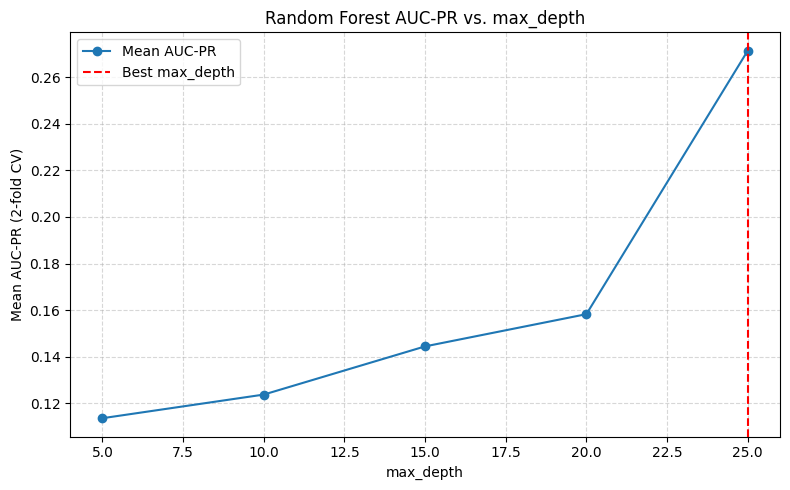

In [16]:
depths = [d if d is not None else 25 for d in param_grid['max_depth']]  # Use 25 to plot 'None'
mean_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(8, 5))
plt.plot(depths, mean_scores, marker='o', label='Mean AUC-PR')
plt.axvline(
    x=depths[param_grid['max_depth'].index(grid_search.best_params_['max_depth'])],
    linestyle='--', color='r', label='Best max_depth'
)
plt.xlabel("max_depth")
plt.ylabel("Mean AUC-PR (2-fold CV)")
plt.title("Random Forest AUC-PR vs. max_depth")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Training the model with the best AUC-PR score (max_depth = None) (Trees are allowed to grow fully)

In [9]:
rf_best = RandomForestClassifier(
    n_estimators=10,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=2,                 
    random_state=42
)
rf_best.fit(X_train, y_train)

# Evaluate on validation set
val_accuracy = rf_best.score(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.9863


In [10]:
from sklearn.metrics import average_precision_score, precision_score, recall_score

In [11]:
y_val_probs = rf_best.predict_proba(X_val)[:, 1]
y_val_pred = rf_best.predict(X_val)

auc_pr_val = average_precision_score(y_val, y_val_probs)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)

print("Test Set Performance:")
print(f"AUC-PR-Validation   : {auc_pr_val:.4f}")
print(f"Precision(Val): {precision_val:.4f}")
print(f"Recall(Val)   : {recall_val:.4f}")

Test Set Performance:
AUC-PR-Validation   : 0.0708
Precision(Val): 0.3390
Recall(Val)   : 0.0287


In [12]:
y_test_probs = rf_best.predict_proba(X_test)[:, 1]
y_test_pred = rf_best.predict(X_test)

auc_pr_test = average_precision_score(y_test, y_test_probs)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

print("Test Set Performance:")
print(f"AUC-PR-Testing  : {auc_pr_test:.4f}")
print(f"Precision(Test): {precision_test:.4f}")
print(f"Recall(Test)   : {recall_test:.4f}")

Test Set Performance:
AUC-PR-Testing  : 0.1193
Precision(Test): 0.4303
Recall(Test)   : 0.0457


In [13]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_test_pred)

print(f"F1 Score : {f1:.4f}")

F1 Score : 0.0826
